# Educatour Modelv1 (Xception)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import os
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

2024-06-05 10:26:09.356142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 10:26:09.356300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 10:26:09.452403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
PATH = '/kaggle/input/educatour-landmark-v2/Dataset 2/'
TRAIN_PATH = PATH+'Train'
TEST_PATH = PATH+'Test'

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

## Load Dataset

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [5]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                               subset="both",
                                                              validation_split=0.2, seed=42)

Found 1872 files belonging to 25 classes.
Using 1498 files for training.
Using 374 files for validation.


## Cek masuk

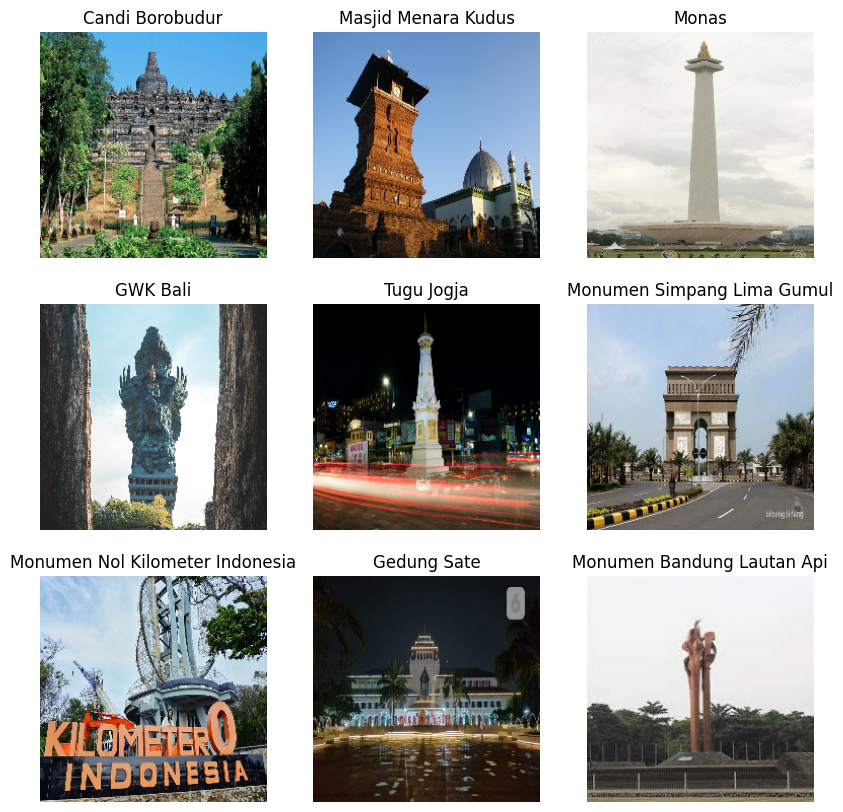

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation Layer

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
])

## Pre fine-tuned model

### Initiate Xception base model

In [8]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [9]:
# Create the base model from the pre-trained model Xception
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
    classes=25,
    classifier_activation='softmax'
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### Freeze the layers

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### Create Classifier Layers

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [14]:
prediction_layer = tf.keras.layers.Dense(25, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


### Customize model predict returnable variable

In [15]:
class MyModel(tf.keras.Model):
    def predict_step(self, data):
        x, y = data
        return self(x, training=False), x, y

### Define Model

In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
model = MyModel(inputs, outputs)

In [17]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │        51,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,912,705 (79.78 MB)

 Trainable params: 51,225 (200.10 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

### Define Callbacks

In [19]:
class LossStopper(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, min_delta=0.001):
        super(LossStopper, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("val_loss")
        if current_loss is None:
            print("Val Loss is not available in logs")
            return

        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nStopping training as loss has not decreased more than {self.min_delta} for {self.patience} epochs.")
                self.model.stop_training = True

### Train Model

In [20]:
initial_epochs = 50
loss_stopper = LossStopper(patience=5, min_delta=0.001)
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, callbacks=[loss_stopper])

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 439ms/step - acc: 0.0648 - loss: 3.2791 - val_acc: 0.0882 - val_loss: 3.1128
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - acc: 0.1401 - loss: 2.9772 - val_acc: 0.2380 - val_loss: 2.8501
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - acc: 0.2962 - loss: 2.7051 - val_acc: 0.3957 - val_loss: 2.6147
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - acc: 0.4448 - loss: 2.4641 - val_acc: 0.5401 - val_loss: 2.3984
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - acc: 0.5577 - loss: 2.2311 - val_acc: 0.6123 - val_loss: 2.2088
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - acc: 0.5978 - loss: 2.0895 - val_acc: 0.6578 - val_loss: 2.0397
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - acc: 0.6856 - loss: 1.8898 - val_acc: 0.6979 - val_loss: 1.8928
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7285 - loss: 1.7592 - val_acc: 0.7166 - val_loss: 1.7632
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/

### Performance

In [21]:
acc = []
val_acc = []
loss = []
val_loss = []

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

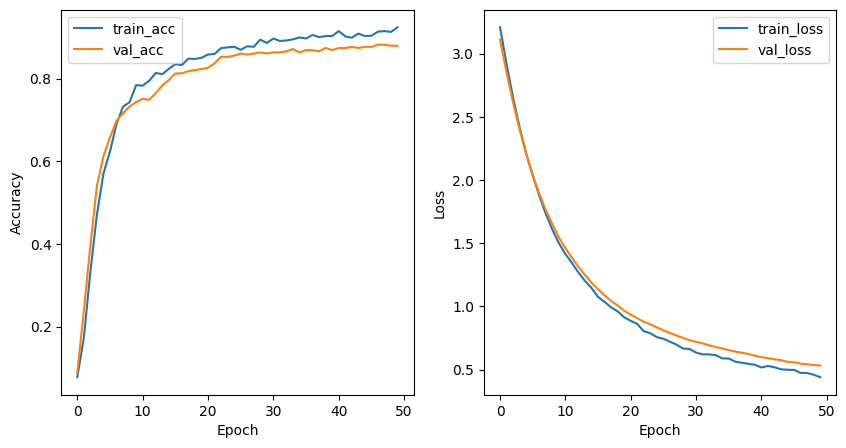

In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(acc, label='train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Save Pre-finetuned model

In [24]:
model_name = '{0}-{1}.h5'.format('modelv1-preft',int(round(val_acc[-1], 2)*100))
pickle.dump(model, open(model_name, 'wb'))

### Try to predict (before fine tune)

In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(TEST_PATH, shuffle=True,
                                                           image_size=IMG_SIZE, batch_size=BATCH_SIZE,)

Found 1872 files belonging to 25 classes.


In [26]:
y_pred, x_true, y_true = model.predict(test_ds)
max_y_pred = np.argmax(y_pred, -1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step


#### Preview Hasil Prediksi Sebelum Fine-tune

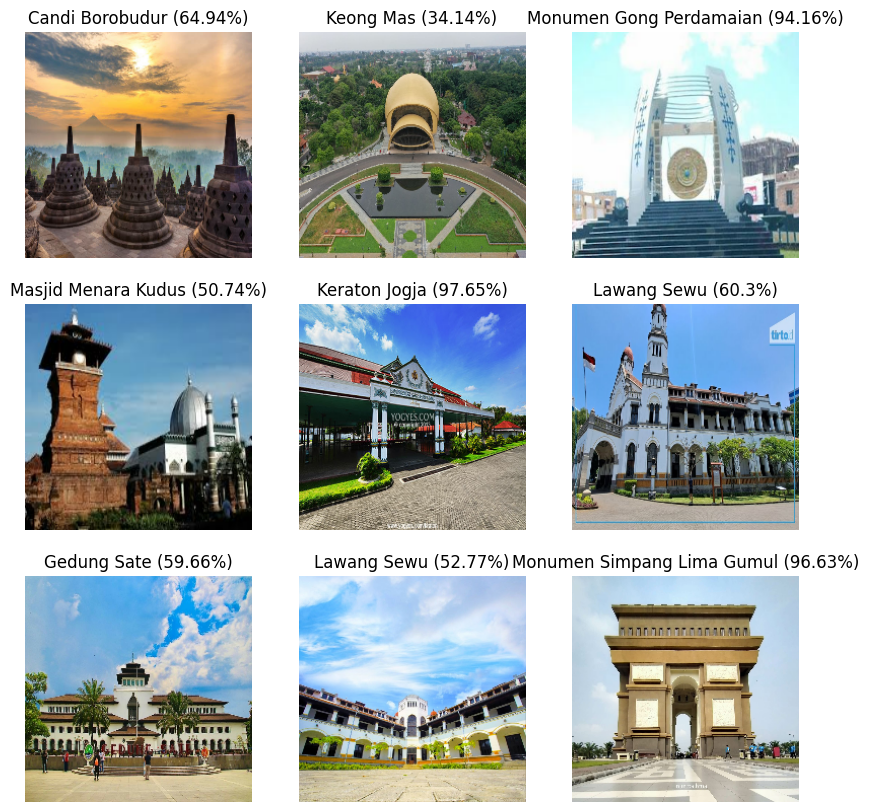

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_true[i].astype("uint8"))
  plt.title("{0} ({1}%)".format(class_names[max_y_pred[i]],
                                round(y_pred[i][max_y_pred[i]]*100, 2)))
  plt.axis("off")

#### Classification Report

In [28]:
print(classification_report(y_true, max_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        74
           1       0.88      0.88      0.88        77
           2       0.82      0.90      0.86        78
           3       0.97      0.93      0.95        71
           4       0.88      0.79      0.83        76
           5       0.89      0.81      0.85        72
           6       0.92      1.00      0.96        76
           7       0.99      0.97      0.98        75
           8       0.86      0.88      0.87        75
           9       0.94      0.86      0.90        74
          10       0.90      0.68      0.77        78
          11       0.82      0.86      0.84        80
          12       0.90      0.93      0.92        75
          13       0.69      0.97      0.81        77
          14       1.00      0.96      0.98        77
          15       0.93      0.92      0.92        73
          16       0.99      0.90      0.94        73
          17       1.00    

#### Confusion Matrix Hasil Prediksi

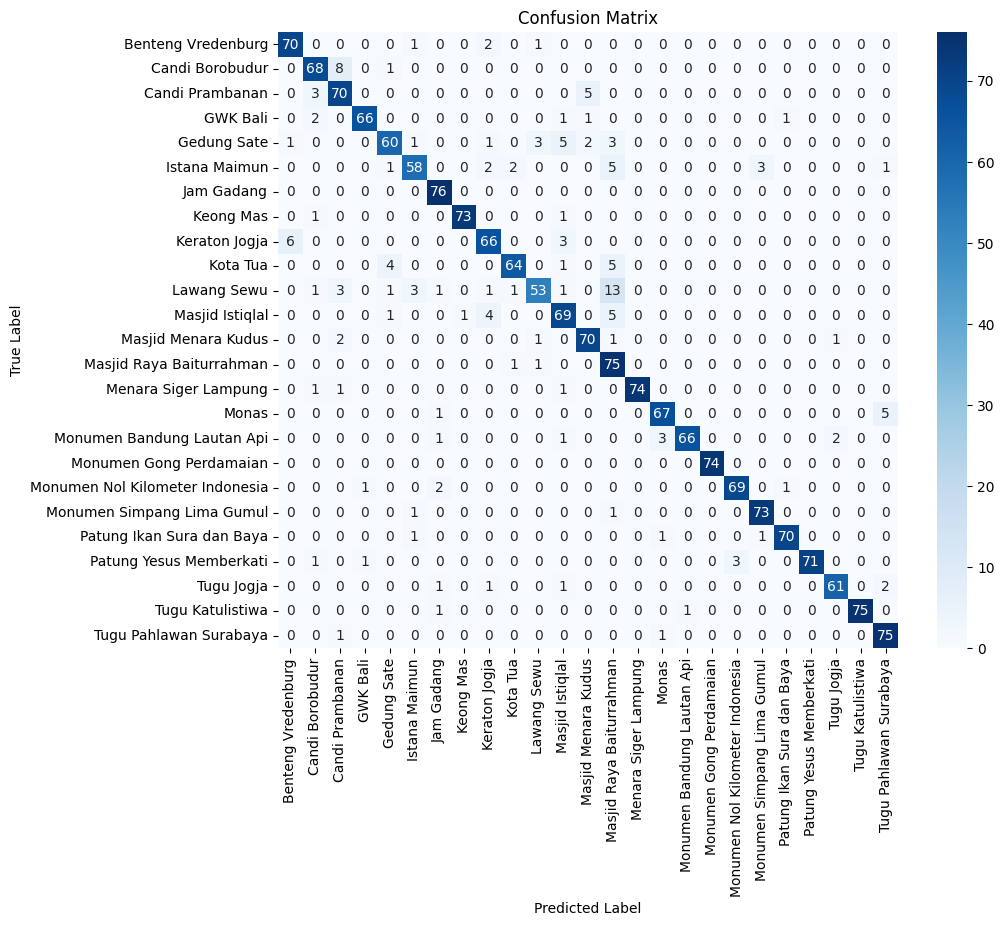

In [29]:
plot_cm(y_true, max_y_pred)

## Fine tuning the model

### Set model layers yang akan difine-tune

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


### Compile and Training Fine-tuned model

In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['acc'])

In [33]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs
loss_stopper_2 = LossStopper(patience=5, min_delta=0.001)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds, callbacks=[loss_stopper_2])


Epoch 51/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 417ms/step - acc: 0.7803 - loss: 1.5951 - val_acc: 0.8797 - val_loss: 0.5055
Epoch 52/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - acc: 0.8345 - loss: 1.2032 - val_acc: 0.8743 - val_loss: 0.4817
Epoch 53/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - acc: 0.8636 - loss: 0.9487 - val_acc: 0.8797 - val_loss: 0.4487
Epoch 54/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - acc: 0.9079 - loss: 0.7571 - val_acc: 0.8984 - val_loss: 0.4195
Epoch 55/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - acc: 0.9068 - loss: 0.6569 - val_acc: 0.9091 - val_loss: 0.4027
Epoch 56/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 352ms/step - acc: 0.9376 - loss: 0.5581 - val_acc: 0.9118 - val_loss: 0.3980
Epoch 57/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - acc: 0.9278 - loss: 0.5030 - val_acc: 0.9198 - val_loss: 0.4032
Epoch 58/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - acc: 0.9537 - loss: 0.4179 - val_acc: 0.9278 - val_loss: 0.3888
Epoch 59/100
47/47 ━━━━━━━━━━━━━

### Hasil Evaluasi Model

In [34]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

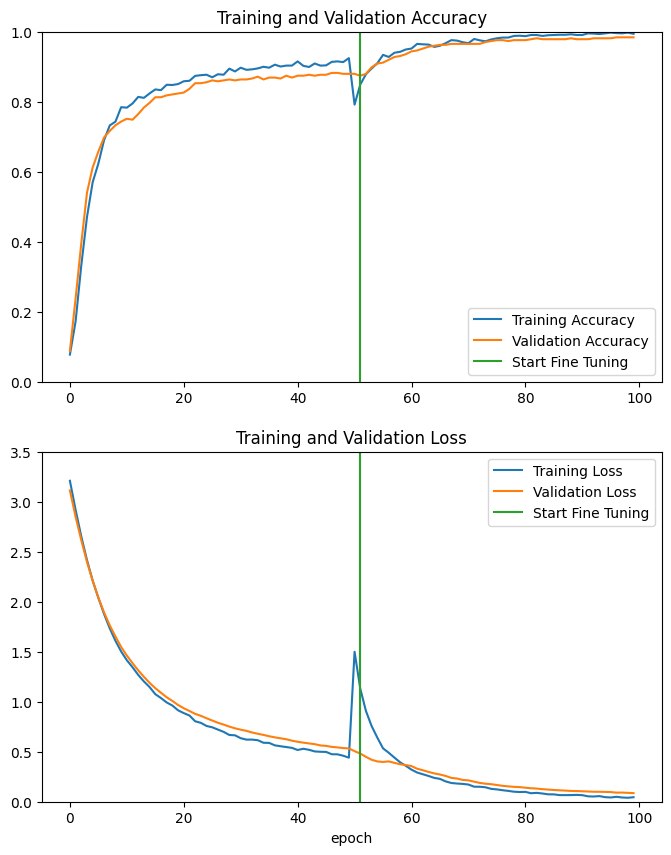

In [35]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([51, 51],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.5])
plt.plot([51, 51],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Export model after fine tune

In [36]:
model_name = '{0}-{1}.h5'.format('modelv1-ft',int(round(val_acc[-1], 2)*100))
pickle.dump(model, open(model_name, 'wb'))

### Prediction after fine tune

In [37]:
y_pred_ft, x_true_ft, y_true_ft = model.predict(test_ds)
max_y_pred_ft = np.argmax(y_pred_ft, -1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step


#### Preview Hasil Prediksi Setelah Fine-tune

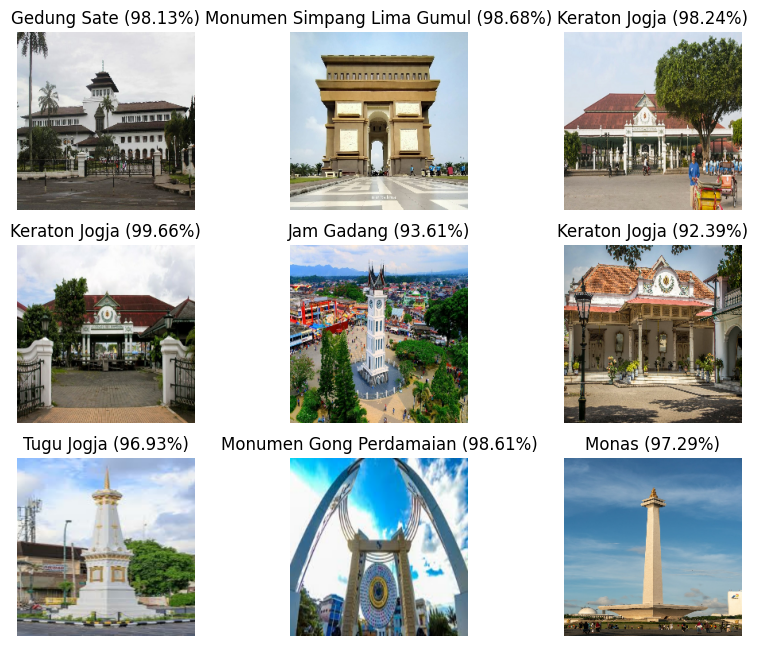

In [38]:
plt.figure(figsize=(10, 30))
for i in range(9):
  ax = plt.subplot(11, 3, i + 1)
  plt.imshow(x_true_ft[i].astype("uint8"))
  plt.title("{0} ({1}%)".format(class_names[max_y_pred_ft[i]], round(y_pred_ft[i][max_y_pred_ft[i]]*100, 2)))
  plt.axis("off")


#### Classification Report Setelah Fine-tune

In [39]:
print(classification_report(y_true_ft, max_y_pred_ft))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       0.99      0.99      0.99        77
           2       0.99      1.00      0.99        78
           3       1.00      0.99      0.99        71
           4       1.00      1.00      1.00        76
           5       1.00      0.99      0.99        72
           6       0.99      1.00      0.99        76
           7       1.00      1.00      1.00        75
           8       1.00      1.00      1.00        75
           9       0.99      1.00      0.99        74
          10       1.00      0.99      0.99        78
          11       1.00      1.00      1.00        80
          12       1.00      1.00      1.00        75
          13       0.99      1.00      0.99        77
          14       1.00      1.00      1.00        77
          15       0.99      1.00      0.99        73
          16       1.00      0.99      0.99        73
          17       1.00    

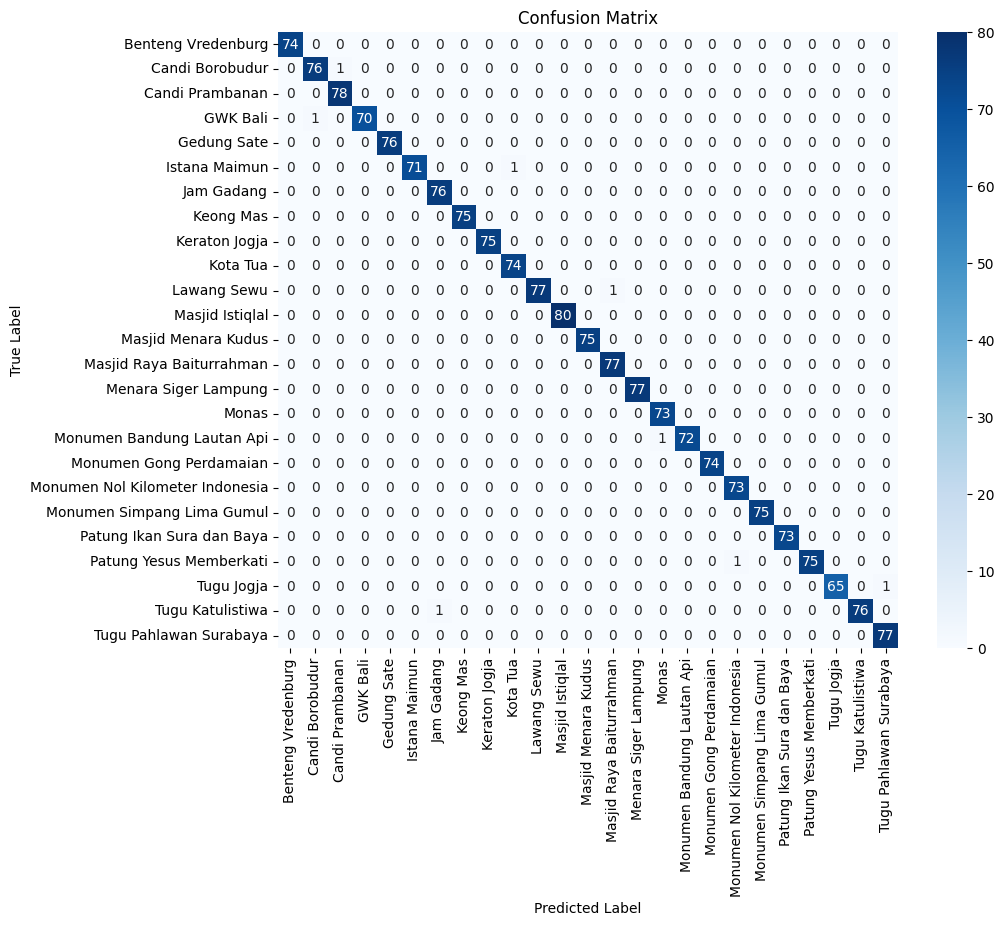

In [40]:
plot_cm(y_true_ft, max_y_pred_ft)